In [9]:
import pandas as pd

from code.parser.parse import Parser
import matplotlib.pyplot as plt
from code.wiener_kolmogorov.wiener_kolmogorov import WienerKolmogorov as WK
from code.detector.detector import  Detector
import numpy as np

pre1 = Parser.read('../../runs/1/pre.txt')
abs1 = Parser.read('../../runs/1/abs.txt')
pre2 = Parser.read('../../runs/2/pre.txt')
abs2 = Parser.read('../../runs/2/abs.txt')

In [10]:
pre1 = pd.concat([pre1, abs1], ignore_index=True)
abs1 = pd.concat([abs1, abs1], ignore_index=True)
pre2 = pd.concat([pre2, abs2], ignore_index=True)
abs2 = pd.concat([abs2, abs2], ignore_index=True)

In [11]:
def filter_out(pres, abss):
    filters = []
    for abs in abss:
        filter = WK()
        filter.fit(abs["rssi"].to_numpy())
        filters.append(filter)
    outs = []
    print(filters)
    for i, pre in enumerate(pres):
        out = filters[i].transform(pre["rssi"].to_numpy())
        outs.append(out)
    return outs, filters

In [12]:
outs, filters = filter_out([pre1, pre2], [abs1, abs2])

[<code.wiener_kolmogorov.wiener_kolmogorov.WienerKolmogorov object at 0x7ff4534a1fd0>, <code.wiener_kolmogorov.wiener_kolmogorov.WienerKolmogorov object at 0x7ff4534a1220>]


In [13]:
ticks = list(range(0, 25, 201))

In [14]:
def subplot(pres, outs, titles):
    fig = plt.figure(figsize=(16, 12))
    n = len(pres)
    axs = []
    k = 1
    # for pre in pres:
    #     for out in outs:
    #         axs.append(fig.add_subplot(n, n, k))
    #         k += 1
    # for pre, out in pres, outs:
    for i, (pre, out) in enumerate(zip(pres, outs)):
        axs.append(fig.add_subplot(n, 1, k))
        axs[k - 1].plot(pre.rssi)
        axs[k - 1].plot(out)
        axs[k - 1].set(title=titles[k-1])
        k += 1
        # axs.append(fig.add_subplot(n, 2, k))
    return fig

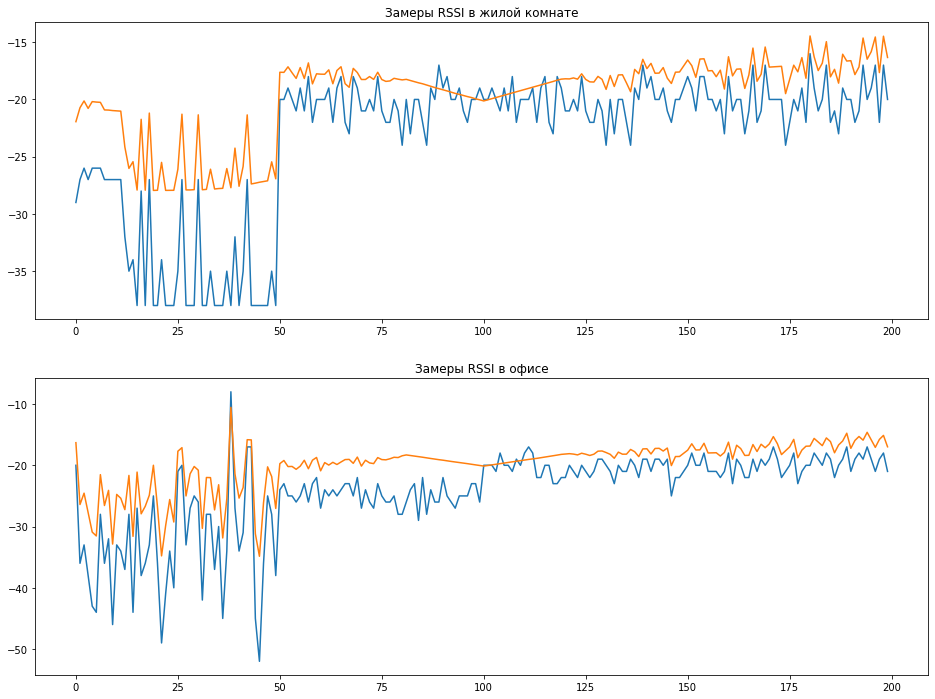

In [15]:
fig = subplot([pre1, pre2], outs, titles=["Замеры RSSI в жилой комнате", "Замеры RSSI в офисе"])
plt.show()

In [16]:
d = Detector()
d.detect(outs[0])

/usr/local/lib/python3.8/dist-packages/numpy/core/fromnumeric.py:3372: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/usr/local/lib/python3.8/dist-packages/numpy/core/_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
